# Computational Methods in Simulation (CMIS) Week 3
This notebook is intended to help students make their hand-in in this week of CMIS.


Hand-ins must be submitted as a maximum 3 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 6 - follow the detailed steps below to learn about mesh representations as well as meash quality measures:

* Explain how a mesh is represented and create a function that can generate a 2D traingle mesh for a beam (large rectangle) shape
* Apply a third-party meshing tool such as tetgen, wildmeshing or similar to a simple 2D case.
* Apply a 3D meshing tool such as TetGen or wildmeshing or similar to a 3D surface mesh such as 'armadillo.obj'
* Identify two or more quality measures from the Shewchuck paper that you believe will be good measures for a linear tetrahedral mesh. Explain pros and cons of your choosen measures (Hint: We provide functions for computing inscribed/circumscriped spheres as well as signed volume).
* Implement the chosen quality measures and create a tool for plotting quality historgrams.
* Compute your chosen quality measures for the 3D volume mesh you generate and display histograms of them. Discuss the histograms, what do they tell you about the mesh you generated?
* Implement the marching triangle method (as described in Slides 6) and identify "bad" or "wrong" triangles created by the method. Discuss the cause of these cases and if time permit develop an improved version of the method (Hint: reuse your signed distance field code from Week 2).  


## Detailed Expected Learning Objectives in The Hand-in of this Week

* Computational Meshing (Slides 6)
    * Explain common mesh quality measures.
    * Implement a simple computational mesh generator.
    * Generate computational quality meshes using 3rd party software such as DistMesh, TetGen or similar.
    * Experimentally evaluate whether a given computational mesh is a quality mesh.

## Mesh Representations

In this work we use the face-indexed array representation for storing a unstructured mesh. That is a triangle mesh. One may find a short description of mesh descriptions from the libigl library

https://libigl.github.io/libigl-python-bindings/tutorials/

For our 3D meshing examples we may make use of the wildmeshing library for both 3D and 2D meshing

https://wildmeshing.github.io/wildmeshing-notebook/

Further, We provide two of our own primitive 2D meshing methods.

In [74]:
%matplotlib widget

In [75]:
import igl
import meshplot as mp
import numpy as np
import wildmeshing as wm
import matplotlib.pyplot as plt

For starters we will show an example of how to directly generate a beam mesh.

The idea is to make the beam on a regular back ground grid. In a first sweep over grid nodes we create the vertices of the beam mesh. In a second sweep over the cells of the regular grid we will create triangles. 

To avoid having any bias from mesh connectivity we choose to flip the diagonals of the grid cells. This way we get a very homogenous looking triangle mesh with similar shaped triangles that are close to being equilateral.

In [76]:
def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

V, T = make_beam_mesh(2.0,1.0,(12,6))

p = mp.plot(V, T, return_plot=True, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Next we will show an example using the wildmeshing library to generate a triangle mesh from a polygon boundary. 

In [77]:
# Documentation is here https://wildmeshing.github.io/wildmeshing-notebook/
def make_circle_mesh(radius, segments):
    K = segments
    X = np.array([ radius*np.cos(2*np.pi*k/K) for k in range(K)])
    Y = np.array([ radius*np.sin(2*np.pi*k/K) for k in range(K)])
    P = np.zeros((K,2))
    P[:,0] = X
    P[:,1] = Y
    L = np.array([(k,(k+1)%K) for k in range(K)],dtype=np.int32)
    V, T, _, _ = wm.triangulate_data(P, L, cut_outside=True)
    return (V, T)

V, T = make_circle_mesh(0.75, 36)

p = mp.plot(V, T, return_plot=True, shading={"wireframe": True})

Loading and preprocessing ...
remove duplicates:
#v 36->36
#e 36->36
simplify:
#v 36->36
#e 36->36
Loaded and preprocessed.
time = 0.000217s

BSP subdivision...
#v 136->136
#f 234->234
BSP subdivision done.
time = 0.000639s

Mesh optimization...
#v = 136(136)    unrounded = 0
#t = 234(234)
max_energy = 5.3028
avg_energy = 2.59881
min_angle = 13.5646, max_angle = 136.836
< 5: 0, < 10: 0, < 15: 0.0299145
> 175: 0, > 170: 0, > 165: 0

//////////////// preprocessing ////////////////
edge collapsing...
queue_s.size() = 652
success 16
re-push 24
queue_s.size() = 34
success 0
re-push 0
edge collapsing done!
time = 0.00041s
#v = 120(136)    unrounded = 0
#t = 202(234)
max_energy = 2.90356
avg_energy = 2.37576
min_angle = 26.6985, max_angle = 104.208
< 5: 0, < 10: 0, < 15: 0
> 175: 0, > 170: 0, > 165: 0

//////////////// postprocessing ////////////////
edge collapsing...
queue_s.size() = 16
success 0
re-push 0
edge collapsing done!
time = 5e-05s
#v = 120(136)    unrounded = 0
#t = 202(234)
max_

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# Quality Measures

We have identified 4 quality measures for linear tetrahedral meshes. We implement simple functions that given one element can compute its quality measure.

For computing quality measures it is helpful to be able to compute the signed volume of a tetrahedron, test if is left oriented, circumscribed and inscriped spheres.

In [78]:
def compute_signed_volume(pi, pj, pk, pm):
    return np.dot((pm - pi), np.cross((pj - pi), (pk - pi))) / 6.0


def is_left_orientation(pi, pj, pk, pm):
    return compute_signed_volume(pi, pj, pk, pm) < 0.0


def compute_circumscribed_sphere(p0, p1, p2, p3):
    A = p0 - p3
    B = p1 - p3
    C = p2 - p3

    M00 = np.dot(A, A)
    M01 = np.dot(A, B)
    M02 = np.dot(A, C)
    M10 = np.dot(B, A)
    M11 = np.dot(B, B)
    M12 = np.dot(B, C)
    M20 = np.dot(C, A)
    M21 = np.dot(C, B)
    M22 = np.dot(C, C)

    M = np.array([[M00, M01, M02], [M10, M11, M12], [M20, M21, M22]], dtype=np.float64)
    q = 0.5 * np.array([M00, M11, M22], dtype=np.float64)
    
    u = np.linalg.lstsq(M, q, rcond=None)[0]

    u0 = u[0]
    u1 = u[1]
    u2 = u[2]
    u3 = 1.0 - u0 - u1 - u2

    radius = np.linalg.norm(u0 * A + u1 * B + u2 * C)
    center = u0 * p0 + u1 * p1 + u2 * p2 + u3 * p3

    return center, radius


def compute_inscribed_sphere(pi, pj, pk, pm):
    nm = np.cross((pj - pi), (pk - pi))
    ni = np.cross((pm - pj), (pk - pj))
    nj = np.cross((pm - pk), (pi - pk))
    nk = np.cross((pm - pi), (pj - pi))
    Lnm = np.linalg.norm(nm)
    Lni = np.linalg.norm(ni)
    Lnj = np.linalg.norm(nj)
    Lnk = np.linalg.norm(nk)
    nm = nm / Lnm
    ni = ni / Lni
    nj = nj / Lnj
    nk = nk / Lnk

    wm = np.dot(nm, pi)
    wi = np.dot(ni, pj)
    wj = np.dot(nj, pk)
    wk = np.dot(nk, pi)

    M00 = nm[0]
    M01 = nm[1]
    M02 = nm[2]
    M03 = -1.0

    M10 = ni[0]
    M11 = ni[1]
    M12 = ni[2]
    M13 = -1.0

    M20 = nj[0]
    M21 = nj[1]
    M22 = nj[2]
    M23 = -1.0

    M30 = nk[0]
    M31 = nk[1]
    M32 = nk[2]
    M33 = -1.0

    A = np.array([[M00, M01, M02, M03], [M10, M11, M12, M13], [M20, M21, M22, M23], [M30, M31, M32, M33]],
                 dtype=np.float64)
    b = np.array([wm, wi, wj, wk], dtype=np.float64)

    x = np.linalg.lstsq(A, b, rcond=None)[0]

    center = np.array( [x[0], x[1], x[2]], dtype=np.float64)
    radius = x[3]

    return center, radius

In [125]:
import math
def compute_area(a, b, c):
    s = (a+b+c)/2
    return np.sqrt(s*(s-a)*(s-b)*(s-c))

def compute_circumscribed_circle(pi, pj, pk):
    center = (pi + pj + pk) / 3
    a = np.linalg.norm(pi-pj)
    b = np.linalg.norm(pj-pk)
    c = np.linalg.norm(pk-pi)
    radius = (a * b * c) / (4 * compute_area(a, b, c))
    return center, radius
def circle_ratio(triangle):
        
        
   
        x1, y1 = triangle[0]
        x2, y2 = triangle[1]
        x3, y3 = triangle[2]
        a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # length of side a
        b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)  # length of side b
        c = math.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)  # length of side c
        s = (a + b + c) / 2  # calculate the semiperimeter
        incircle_radius = math.sqrt(((s - a) * (s - b) * (s - c)) / s)  # calculate the radius of the inscribed circle
        circumcircle_radius = compute_circumscribed_circle(triangle[0],triangle[1],triangle[2])[1]
        ratio = 3*incircle_radius / circumcircle_radius  # calculate the ratio
        
       
        return ratio


Now we may implement our quality measures using these basic geometry functions

In [117]:
# TODO - identify two or more quality measures from the Shewchuck paper that you believe will be good 
# measures for a linear tetrahedral mesh and implement them below

def compute_quality_1(points):
    p0, p1, p2, p3 = points
    
    A = p0 - p3
    B = p1 - p3
    C = p2 - p3
    D = p2 - p1
    E = p1 - p0
    F = p2 - p0
    
    edges = [A,B,C,D,E,F]
    edge_lengths = [np.linalg.norm(A), np.linalg.norm(B), np.linalg.norm(C), np.linalg.norm(D), np.linalg.norm(E), np.linalg.norm(F)]
    
    return 2*np.sqrt(6)*(compute_inscribed_sphere(p0, p1, p2, p3)[1]/np.max(edge_lengths))



    
    
    
    

def compute_quality_2(points):
    p0, p1, p2, p3 = points
    return 3*(compute_inscribed_sphere(p0, p1, p2, p3)[1]/compute_circumscribed_sphere(p0, p1, p2, p3)[1])
    
# these are optional    
#def compute_quality_3(points):
#    p0, p1, p2, p3 = points
#    12*((3*compute_signed_volume(p0, p1, p2, p3))**(2/3))/

#def compute_quality_4(points):
   

Finally we can create a function that iterates over all tetrahedra in a mesh, compute quality measures for each tetrahedron and make histograms of the measures

In [123]:
def gen_hist_for_vals(vals):
    n, bins, patches = plt.hist(x=vals, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('')
    plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    


def plot_quality_histograms(vertices, tets):
    vals_1 = []
    
    for elm in tets:
        points = []
        for vert in elm:
            points.append(vertices[vert])
        if circle_ratio(points) > 1 :print(circle_ratio(points))
        vals_1.append(circle_ratio(points))
        
    #gen_hist_for_vals(vals_1)
    #plt.show()
    gen_hist_for_vals(vals_1)
    plt.show()
   




# Reading Surface Mesh from File

We want to get some test geometry for making 3D tetrahedral meshes. We will use a popular computer graphics figure for our testing.

In [82]:
v, f = igl.read_triangle_mesh("armadillo.obj")
mp.plot(v, f, v[:, 0])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.015966…

# Create Volumetric Tetrahedral Mesh from Surface Mesh

We can now invoke a meshing routine to get a volume mesh and then visualize it.

In [83]:
tetra = wm.Tetrahedralizer(stop_quality=500)
tetra.load_mesh("armadillo.obj")
tetra.tetrahedralize()
V, T = tetra.get_tet_mesh()
mp.plot(V, T)

TBB threads 12
                 Loading file armadillo.obj...
                 (FP64) nb_v:43243 nb_e:0 nb_f:86482 nb_b:0 tri:1 dim:3
                 Attributes on vertices: point[3]
bbox_diag_length = 1.51164
ideal_edge_length = 0.0755821
stage = 2
eps_input = 0.00151164
eps = 0.00083683
eps_simplification = 0.000669464
eps_coplanar = 1.51164e-06
dd = 0.00100776
dd_simplification = 0.000806209
[2023-05-12 17:16:10.763] [float-tetwild] [info] remove duplicates: 
[2023-05-12 17:16:10.764] [float-tetwild] [info] #v: 43243 -> 43243
[2023-05-12 17:16:10.764] [float-tetwild] [info] #f: 86482 -> 86482
collapsing 2.5331
swapping 0.506224
[2023-05-12 17:16:13.863] [float-tetwild] [info] remove duplicates: 
[2023-05-12 17:16:13.863] [float-tetwild] [info] #v: 17774 -> 17774
[2023-05-12 17:16:13.863] [float-tetwild] [info] #f: 35544 -> 35544
[2023-05-12 17:16:13.866] [float-tetwild] [info] #v = 17774
[2023-05-12 17:16:13.866] [float-tetwild] [info] #f = 35543
#boundary_e1 = 2
#boundary_e2 = 4
[

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.015817…

# Histograms of Quality Measures from 3D Volume Mesh

We now have all pieces in place to make histograms. We can use the histograms to get an idea of the quality of the mesh we have created.

In [113]:
plot_quality_histograms(V, T)

ValueError: too many values to unpack (expected 2)

Just for fun we will play with a few more meshes to see how they behave

In [ ]:
tetra = wm.Tetrahedralizer(stop_quality=500)
tetra.load_mesh("left_brain.stl")
tetra.tetrahedralize()
V, T = tetra.get_tet_mesh()
mp.plot(V, T)
plot_quality_histograms(V, T)

TBB threads 12
                 Loading file left_brain.stl...
                 Error: Could not load file: left_brain.stl


ValueError: Invalid mesh path at left_brain.stl

In [ ]:
tetra = wm.Tetrahedralizer(stop_quality=500)
tetra.load_mesh("right_brain.stl")
tetra.tetrahedralize()
V, T = tetra.get_tet_mesh()
mp.plot(V, T)
plot_quality_histograms(V, T)

: 

# Marching Triangles

We will reuse some of our code from week 2. Particular we need the function that can compute a signed distance field. This is because we want to apply the marching triangle method on a signed distance field.

In [85]:
def vec2(x,y):
    return np.array([x,y], dtype=np.float64)


def compute_signed_distance(poly, q):
    
    def is_left(p0, p1, p2):
        return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])

    N = poly.shape[0]
    d = np.inf

    # Compute distance to closest surface point
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        
        ba = b - a     # Vector from a to b
        bal = np.linalg.norm(ba) # Length of ba vector
        if bal == 0:
            continue
        ban = ba / bal # Normal of the vector from a to b
        qa = q - a     # The vector from the query point to a
        alpha = np.dot(qa, ban) / bal
        if alpha < 0:
            da = np.linalg.norm(q-a)
            if da < d:
                d = da
        elif alpha > 1:
            db = np.linalg.norm(q-b)
            if db < d:
                d = db
        else:
            banp = np.array([-ban[1], ban[0]])
            dp = abs(np.dot(qa, banp))
            if dp < d:
                d = dp
    # Compute winding number to set the sign
    wn = 0
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        if a[1] <= q[1]:
            if b[1] > q[1]:
                if is_left(a, b, q) > 0:
                    wn = wn + 1
        else:
            if b[1] <= q[1]:
                if is_left(a, b, q) < 0:
                    wn = wn -1
    if wn < -0.5:
        d = -d
    elif wn > 0.5:
        d = -d
    return d

The marching triangles method creates a regular background grid and then evaluates the signed distance field value at all grid points. Hereafer each cell is visited iteratively. The cell is cut into two triangles and each triangle is investigated. The triangle vertex order are shuffled such that all interior vertices comes first. 

We may now analyse the triangle case by assigning a case number to the triangle from a binary mask created from its inside-outside pattern of the vertices. The case number identifies a stencil for how to "cut" the triangle and generate triangles that covers the interior of the distance field.

In [103]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(10000)

def root_search(poly, p1, p2):
    print('p1 dist',compute_signed_distance(poly, p1))
    print('p2 dist', compute_signed_distance(poly, p2))
    # TODO - implement the root search algorithm (as described in Slides 7) 
    mid = (p1 + p2) / 2
    #print(mid)
    d = compute_signed_distance(poly, mid)
    print('mid dist', d)
    if abs(d) < 0.01:
        return mid
    else:
        if d < 0:
            return root_search(poly, p1, mid)
        else:
            return root_search(poly, mid, p2)





def marching_triangles(poly, I, J):
    count = 0
    min_coord = vec2(-2,-2)
    max_coord = vec2(2,2)
    I = I  # Number of nodes along x axis
    J = J  # Number of nodes along y axis
    
    res = np.array([I-1, J-1], dtype=np.float64)
    dims = (max_coord - min_coord)
    spacing = np.divide( dims, res)
    
    dx = spacing[0]
    dy = spacing[1]
    x = np.linspace(min_coord[0], max_coord[0], I)
    y = np.linspace(min_coord[1], max_coord[1], J)

    X, Y = np.meshgrid(x, y)
    
    v = []
    triangles = []


    for i in range(len(x)):
        for j in range(len(y)):
            v.append(vec2(x[i],y[j]))
           


    
   
    
    for i in range(len(x)-1):
        for j in range(len(y)-1):
            flip = ((i%2) +(j%2))%2
            
            v1 = I*(j) + i
            v2 = I*(j) + i + 1
            v3 = I*(j+1) + i
            v4 = I*(j+1) + i + 1
            if(flip):
                t_1 = [v1,v2,v4]
                t_2 = [v1,v4,v3]
            else:
                t_1 = [v3,v1,v2]
                t_2 = [v3,v2,v4]
            triangles.append(t_1)
            triangles.append(t_2)

    f= []

    draw = []
    for elm in triangles:
        points = [compute_signed_distance(poly, v[p]) for p in elm]
    
        points_tmp = np.array(points)

        
        points = [0 if vertex > 0 else 1 for vertex in points_tmp]
        #rint(points)


        stencil = (points[0] *1) + (points[1] *2) + (points[2] * 4)
        
        apply_rule = 0
        if(stencil == 0):
            apply_rule = 0
        if(stencil == 1):
            apply_rule = 1
            draw = [elm[0], elm[1], elm[2]]
        if(stencil == 2):
            apply_rule = 1
            draw = [elm[1], elm[2], elm[0]]
        if(stencil == 3):
            apply_rule = 2
            draw = [elm[0], elm[1], elm[2]]
        if(stencil == 4):
            apply_rule = 1
            draw = [elm[2], elm[0], elm[1]]
        if(stencil == 5):
            apply_rule = 2
            draw = [elm[2], elm[0], elm[1]]
        if(stencil == 6):
            apply_rule = 2
            draw = [elm[1], elm[2], elm[0]]
        if(stencil == 7):
            apply_rule = 3

        #if (apply_rule == 1) or (apply_rule == 2):
        #    pointstt = np.array([compute_signed_distance(poly, v[p]) for p in draw])
        #    print([0 if vertex > 0 else 1 for vertex in pointstt])
        #    print('rule', apply_rule)
        


        if apply_rule == 3:
            count += 1
            f.append(elm)

       
        if apply_rule == 2:
            count += 1
            cut_1 = root_search(poly, v[draw[2]], v[draw[0]]) #rootSearch(poly, v[draw[0]], v[draw[2]], 0.1)
            cut_2 = root_search(poly, v[draw[2]], v[draw[1]]) #rootSearch(poly, v[draw[1]], v[draw[2]], 0.1)

            coord_a = cut_2
            coord_b = cut_1
            
            index_a = len(v)
            index_b = len(v)+1
            f.append([draw[0],draw[1], index_b])
            f.append([draw[1], index_a, index_b])
            v.append(coord_a)
            v.append(coord_b)

        if apply_rule == 1:
            count += 1
            cut_3 = root_search(poly, v[draw[2]], v[draw[0]]) #rootSearch(poly, v[draw[0]], v[draw[2]], 0.1)
            cut_4 = root_search(poly, v[draw[1]], v[draw[0]]) #rootSearch(poly, v[draw[0]], v[draw[1]], 0.1)
            coord_a = cut_3
            coord_b = cut_4
            
            index_a = len(v)
            index_b = len(v)+1
            f.append([draw[0], index_a, index_b])
            v.append(coord_a)
            v.append(coord_b)

            
        
        

    



    #Use grid with (2,2) and (0,0) as top right and bottom left corners
    #Generate signed distance field from polygon

    #TODO - implement the marching triangles method (as described in Slides 6) 
    print('count',count)
    return np.array(v), f    
        

    




10000


We may now apply the marching triangle to a test problem

In [126]:
poly = np.zeros((9,2),dtype=np.float64)
poly[0,:] = vec2(-1,-1)
poly[1,:] = vec2(-0.5,-1)
poly[2,:] = vec2(-0.5,0.5)
poly[3,:] = vec2(0.5,0.5)
poly[4,:] = vec2(0.5,-1)
poly[5,:] = vec2( 1,-1)
poly[6,:] = vec2( 1, 1)
poly[7,:] = vec2(-1, 1)
poly[8,:] = vec2(-1,-1)

v, f = marching_triangles(poly, 15, 15)

#fig = plt.figure()



##plt.plot(poly[:,0],poly[:,1])
#plt.triplot(v[:,0], v[:,1], f)
#plt.show()

p1 dist 0.1428571428571428
p2 dist -0.1428571428571428
mid dist -0.0
p1 dist 0.1428571428571428
p2 dist -0.1428571428571428
mid dist -0.0
p1 dist 0.1428571428571428
p2 dist -0.1428571428571428
mid dist -0.0
p1 dist 0.1428571428571428
p2 dist -0.07142857142857162
mid dist -0.0
p1 dist 0.1428571428571428
p2 dist -0.07142857142857162
mid dist -0.0
p1 dist 0.1428571428571428
p2 dist -0.07142857142857162
mid dist -0.0
p1 dist 0.1428571428571428
p2 dist -0.07142857142857162
mid dist -0.0
p1 dist 0.25753937681885625
p2 dist -0.07142857142857162
mid dist 0.07142857142857129
p1 dist 0.07142857142857129
p2 dist -0.07142857142857162
mid dist -2.220446049250313e-16
p1 dist 0.25753937681885625
p2 dist -0.07142857142857162
mid dist 0.07142857142857129
p1 dist 0.07142857142857129
p2 dist -0.07142857142857162
mid dist -2.220446049250313e-16
p1 dist 0.2142857142857142
p2 dist -0.07142857142857162
mid dist 0.07142857142857129
p1 dist 0.07142857142857129
p2 dist -0.07142857142857162
mid dist -2.220446049

1.2426406871192854
1.0249223594996206
1.2426406871192854
1.2426406871192852
1.2426406871192854
1.2426406871192854
1.2426406871192852
1.2426406871192854
1.2426406871192852
1.2426406871192854
1.2426406871192848
1.2426406871192854
1.2426406871192852
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.024922359499623
1.2426406871192848
1.2426406871192854
1.0249223594996202
1.2426406871192857
1.2426406871192854
1.2426406871192854
1.2426406871192857
1.2426406871192857
1.2426406871192857
1.2426406871192848
1.2426406871192845
1.2426406871192845
1.2426406871192857
1.2426406871192852
1.2426406871192857
1.2426406871192857
1.2426406871192857
1.2426406871192857
1.2426406871192854
1.2426406871192857
1.2426406871192854
1.0249223594996228
1.2426406871192845
1.2426406871192854
1.0249223594996206
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.2426406871192854
1.24264068711

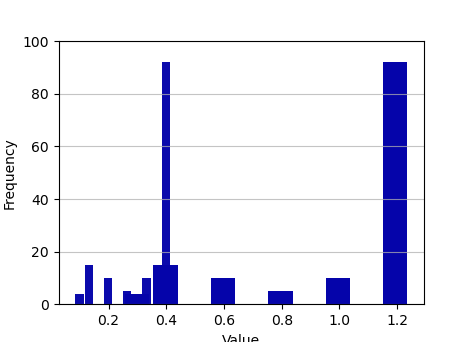

In [127]:
plot_quality_histograms(v,f)

We may observe several issues with the current implementation. Particular at corners we can see sampling side effects. The method can be fooled to believe the whole area of a triangle is part of the inside if all vertices are inside. Likewise it can be fooled to think a triangle is completely outside if none of the vertices are interior. For instance the in the case of the polygon overlapping only one edge of the triangle.

Besides these sampling artefacts we may also note that the current implementation generates redundant vertices. When a triangle is cut by the zero-level set then the intersection points that is computed are not re-used when dealing with neighboring triangles that share the same intersection points.

That is it folks!